In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits() # Load dataset as a dictionary-like object.
print("The digits dataset keys:", digits.keys())
print("The digits dataset description:\n", digits.DESCR)

X, y = digits.data, digits.target
print("The digits dataset features (X) shape:", X.shape)
print("The digits dataset labels (y) shape:", y.shape)


The digits dataset keys: dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
The digits dataset description:
 .. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training 

flattened vector: [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
original image:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
label: 0


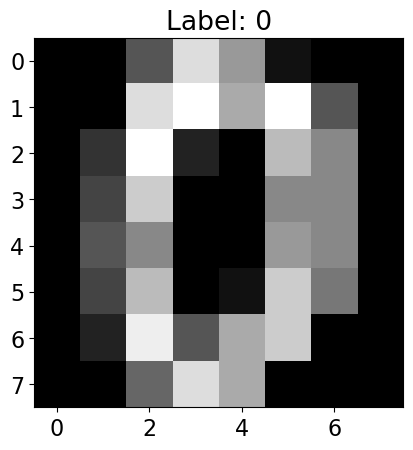

In [11]:
# Plot first image
print("flattened vector:", X[0])
print("original image:\n", digits.images[0])
print("label:", y[0])
plt.imshow(digits.images[0], cmap='gray')
plt.title(f'Label: {digits.target[0]}')
plt.show()

## (i) ##

In [12]:
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Normalize features
scaler = StandardScaler() # Creates a scaler object that standardizes features to have mean = 0 and std = 1.
X_train = scaler.fit_transform(X_train) # Fit and transform the training data
X_val = scaler.transform(X_val) # Transform the validation data
X_test = scaler.transform(X_test) # Transform the test data

# Print the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (1257, 64), (1257,)
Validation set shape: (270, 64), (270,)
Test set shape: (270, 64), (270,)


## (ii) ##

In [13]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
reshaped = y_train.reshape(len(y_train), 1) # 1D array to 2D array
Ytr_onehot = onehot_encoder.fit_transform(reshaped)

reshaped = y_val.reshape(len(y_val), 1)
Yval_onehot = onehot_encoder.fit_transform(reshaped)

reshaped = y_test.reshape(len(y_test), 1)
Yts_onehot = onehot_encoder.fit_transform(reshaped)

Yts_onehot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

## (iii) ##

In [14]:
def ReLU(z):
    return np.maximum(0, z)

def Softmax(z,eps=1e-15):
    z_max = np.max(z, axis=-1, keepdims=True)  # for numerical stability
    exp_z = np.exp(z - z_max)
    pred_Y = exp_z / np.sum(exp_z, axis=-1, keepdims=True)

    # Clip predictions to prevent log(0)
    pred_Y = np.clip(pred_Y, eps, 1 - eps)
    
    return pred_Y
  

def cross_entropy_cost(Y, Y_hat):
    return -np.sum(Y * np.log(Y_hat)) / Y.shape[0]

def forward_pass(X, W1, W2, W3):
    # first layer output
    O1=ReLU(X @ W1)

    # second layer output
    # Column of 1s for bias term
    ones = np.ones((O1.shape[0], 1))
    # Concatenate along columns (axis=1)
    A2 = np.hstack((ones, O1))
    O2 = ReLU(A2 @ W2)

    # third layer output
    ones = np.ones((O2.shape[0], 1))
    A3 = np.hstack((ones, O2))
    Y_hat = Softmax(A3 @ W3)

    return Y_hat, A3, A2, O2, O1

# backward pass for output layer
def backward_pass_output(Y, Y_hat, A3, W3, lr):

    N=Y.shape[0]

    # Error at output layer
    E3 = Y_hat-Y
    # Gradient at output layer
    G3 = (A3.T @ E3)/N
    # Weights update at output layer
    W3_new = W3 - lr * G3

    return E3, G3, W3_new

# backward pass for hidden layer
def backward_pass_hidden(E_ladd1, W_ladd1, A_l, O_l, W_l, lr):
    
    N = A_l.shape[0]
    # Error at hidden layer l
    E_l = E_ladd1 @ W_ladd1[1:].T * (O_l > 0)  # ReLU derivative
    # Gradient at hidden layer l
    G_l = (A_l.T @ E_l)/N
    # Weights update at hidden layer l
    W_l_new = W_l - lr * G_l

    return E_l, G_l, W_l_new


In [15]:
def MLP_3layer(X, Y, W1_init, W2_init, W3_init, lr, num_iters):
    W1, W2, W3 = W1_init.copy(), W2_init.copy(), W3_init.copy() 
    # Create a copy of the initial weights to work out.
    cost_vec = np.zeros(num_iters+1)
    for i in range(1, num_iters+1):
        Y_hat, A3, A2, O2, O1 = forward_pass(X, W1, W2, W3)
        cost = cross_entropy_cost(Y, Y_hat)
        if i % 1000 == 1:
            print(f"Iteration {i-1}, Cost: {cost}")
        cost_vec[i-1]=cost
        E3, G3, W3_new = backward_pass_output(Y, Y_hat, A3, W3, lr) 
        E2, G2, W2_new = backward_pass_hidden(E3, W3, A2, O2, W2, lr)
        E1, G1, W1_new = backward_pass_hidden(E2, W2, X, O1, W1, lr)

        W1, W2, W3 = W1_new.copy(), W2_new.copy(), W3_new.copy()
        # W=W_new.copy(): avoid modifying the original weights. 
        #                 Creates a new array W in memory with the same values as W_new.
        #                 This is a deep copy, so changes to W won’t affect W_new, and vice versa.
        # W=W_new: Only creates a new reference pointing to the same array.
        #          Changes to W would affect W_new, because they share the same memory, and vice versa.

    Y_hat, A3, A2, O2, O1 = forward_pass(X, W1, W2, W3)
    cost = cross_entropy_cost(Y, Y_hat)
    cost_vec[i]=cost
    print(f"Final cost: {cost}")
    
    return Y_hat, cost_vec, W1, W2, W3


In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

order = 1
# Create polynomial features X to P
Poly = PolynomialFeatures(order)
X_train_poly = Poly.fit_transform(X_train)
X_val_poly = Poly.fit_transform(X_val)
X_test_poly = Poly.fit_transform(X_test)

hid_layer_size = 32

# output layer size = number of classes
output_layer_size = Ytr_onehot.shape[1]

# Initialize weights
np.random.seed(42)  # For reproducibility
W1 = np.random.randn(X_train_poly.shape[1], hid_layer_size) # Generates random numbers from a standard normal distribution
W2 = np.random.randn(hid_layer_size+1, hid_layer_size)
W3 = np.random.randn(hid_layer_size+1, output_layer_size)

lr=0.01
num_iters = 20000

Ytr_est, cost_vec_32, W1_new_32, W2_new_32, W3_new_32 = MLP_3layer(X_train_poly, Ytr_onehot, W1, W2, W3, lr, num_iters)
train_acc = accuracy_score(y_train, np.argmax(Ytr_est, axis=1))
print(f"Training accuracy for learning rate {lr}: {train_acc}")
Yval_est,_,_,_,_= forward_pass(X_val_poly, W1_new_32, W2_new_32, W3_new_32)
val_acc = accuracy_score(y_val, np.argmax(Yval_est, axis=1))
print(f"Validation accuracy for learning rate {lr}: {val_acc}")

Iteration 0, Cost: 32.10699292419009
Iteration 1000, Cost: 0.10250190580584198
Iteration 2000, Cost: 0.004684024162043155
Iteration 3000, Cost: 0.001978936441445988
Iteration 4000, Cost: 0.00127945399695216
Iteration 5000, Cost: 0.0009486657238802028
Iteration 6000, Cost: 0.0007564356152755184
Iteration 7000, Cost: 0.0006294643310930292
Iteration 8000, Cost: 0.0005398219558695212
Iteration 9000, Cost: 0.000472929382401217
Iteration 10000, Cost: 0.00042108714418261973
Iteration 11000, Cost: 0.0003797143000426755
Iteration 12000, Cost: 0.00034505978221333186
Iteration 13000, Cost: 0.00031606090140686653
Iteration 14000, Cost: 0.00029175717370583186
Iteration 15000, Cost: 0.00027104395281002305
Iteration 16000, Cost: 0.0002531555455363186
Iteration 17000, Cost: 0.00023748821191946996
Iteration 18000, Cost: 0.00022371979707000867
Iteration 19000, Cost: 0.0002114708173557738
Final cost: 0.00020043299070382164
Training accuracy for learning rate 0.01: 1.0
Validation accuracy for learning rat

Text(0.5, 1.0, '3-layer MLP')

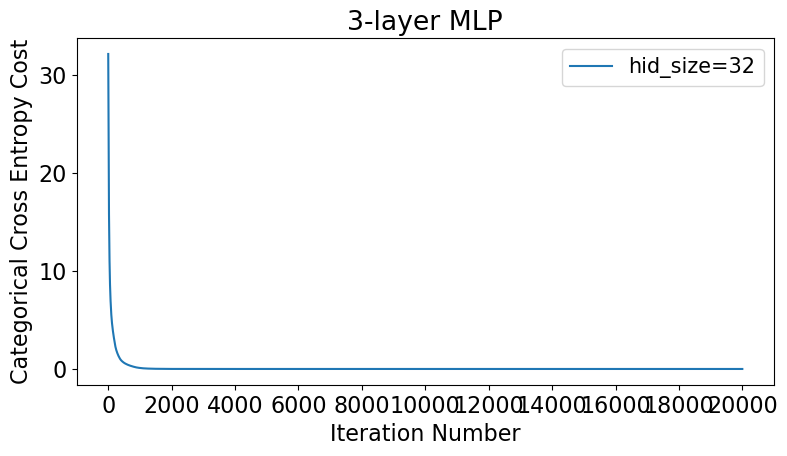

In [17]:
# Plot cost function values over iterations for each learning rate
plt.figure(0, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0, num_iters+1, 1), cost_vec_32, label=f'hid_size={hid_layer_size}')
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('Iteration Number')
plt.ylabel('Categorical Cross Entropy Cost')
plt.xticks(np.arange(0, num_iters+1, 2000))
plt.title('3-layer MLP')

## (iv) ##

Iteration 0, Cost: 28.722528088516075
Iteration 1000, Cost: 0.042660597465105435
Iteration 2000, Cost: 0.001980880907725856
Iteration 3000, Cost: 0.0009133508435663205
Iteration 4000, Cost: 0.0006049269424196868
Iteration 5000, Cost: 0.0004560644605340451
Iteration 6000, Cost: 0.0003677352866574043
Iteration 7000, Cost: 0.0003090946202050405
Iteration 8000, Cost: 0.00026701518683581776
Iteration 9000, Cost: 0.0002353055646411596
Iteration 10000, Cost: 0.00021051188810576485
Iteration 11000, Cost: 0.00019062061327130834
Iteration 12000, Cost: 0.0001743317275208326
Iteration 13000, Cost: 0.0001607063641310009
Iteration 14000, Cost: 0.0001491446696464549
Iteration 15000, Cost: 0.00013919144600994213
Iteration 16000, Cost: 0.00013052829587398195
Iteration 17000, Cost: 0.00012293205749593
Iteration 18000, Cost: 0.00011620445380787813
Iteration 19000, Cost: 0.00011020410376014887
Final cost: 0.00010481265803377828
Training accuracy for hidden layer size 36: 1.0
Validation accuracy for hidden

Text(0.5, 1.0, '3-layer MLP')

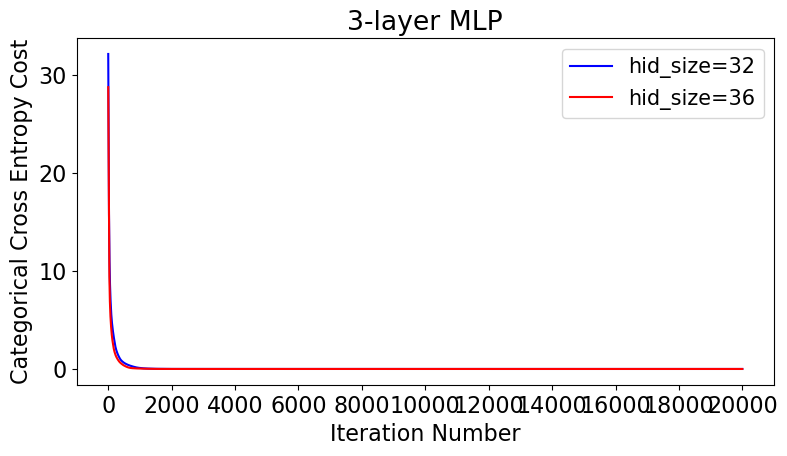

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix

order = 1
# Create polynomial features X to P
Poly = PolynomialFeatures(order)
X_train_poly = Poly.fit_transform(X_train)
X_val_poly = Poly.fit_transform(X_val)
X_test_poly = Poly.fit_transform(X_test)

hid_layer_size = 36
output_layer_size = Ytr_onehot.shape[1]

# Initialize weights
np.random.seed(42)  # For reproducibility
W1 = np.random.randn(X_train_poly.shape[1], hid_layer_size)
W2 = np.random.randn(hid_layer_size+1, hid_layer_size)
W3 = np.random.randn(hid_layer_size+1, output_layer_size)

lr=0.01
num_iters = 20000

Ytr_est, cost_vec_36, W1_new_36, W2_new_36, W3_new_36 = MLP_3layer(X_train_poly, Ytr_onehot, W1, W2, W3, lr, num_iters)
train_acc = accuracy_score(y_train, np.argmax(Ytr_est, axis=1))
print(f"Training accuracy for hidden layer size {hid_layer_size}: {train_acc}")
Yval_est,_,_,_,_= forward_pass(X_val_poly, W1_new_36, W2_new_36, W3_new_36)
val_acc = accuracy_score(y_val, np.argmax(Yval_est, axis=1))
print(f"Validation accuracy for hidden layer size {hid_layer_size}: {val_acc}")

# Plot cost function values over iterations for each learning rate
plt.figure(0, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0, num_iters+1, 1), cost_vec_32, c='b', label='hid_size=32')
plt.plot(np.arange(0, num_iters+1, 1), cost_vec_36, c='r', label='hid_size=36')
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('Iteration Number')
plt.ylabel('Categorical Cross Entropy Cost')
plt.xticks(np.arange(0, num_iters+1, 2000))
plt.title('3-layer MLP')

In [19]:
# evaluate on test set
Yts_est,_,_,_,_= forward_pass(X_test_poly, W1_new_32, W2_new_32, W3_new_32)
test_acc = accuracy_score(y_test, np.argmax(Yts_est, axis=1))
print(f"test accuracy for hidden layer size=32: {test_acc}")
cm_test = confusion_matrix(y_test, np.argmax(Yts_est, axis=1))
print("Confusion Matrix for Test Set:")
print(cm_test)

test accuracy for hidden layer size=32: 0.8444444444444444
Confusion Matrix for Test Set:
[[28  0  1  0  0  0  0  0  1  1]
 [ 0 18  3  0  0  0  1  0  1  1]
 [ 0  0 26  1  0  0  0  0  0  0]
 [ 0  0  3 27  0  1  0  0  1  1]
 [ 0  0  0  0 27  0  0  0  2  0]
 [ 1  0  1  0  1 22  0  0  0  2]
 [ 0  0  0  0  0  0 22  0  1  0]
 [ 0  0  0  0  0  0  0 26  0  1]
 [ 0  1  0  1  3  1  0  3 14  2]
 [ 0  0  0  5  1  0  0  0  0 18]]


### Use sklearn's library ###

In [20]:
from sklearn.neural_network import MLPClassifier

hid_layer_size_list = [32, 36]
train_acc_list = {}
val_acc_list = {}
max_val_acc = 0
best_size = 0

for hid_layer_size in hid_layer_size_list:
    # Define MLP and fit once to initialize shapes
    mlp = MLPClassifier(hidden_layer_sizes=(hid_layer_size, hid_layer_size), 
                        solver='sgd',
                        max_iter=num_iters, 
                        learning_rate_init=lr,
                        random_state=42)
    mlp.fit(X_train, y_train)

    ytr_pred = mlp.predict(X_train)
    train_acc = accuracy_score(y_train, ytr_pred)
    print(f"Training accuracy for hidden layer size {hid_layer_size}: {train_acc}")
    train_acc_list[hid_layer_size]=train_acc

    yval_pred = mlp.predict(X_val)
    val_acc = accuracy_score(y_val, yval_pred)
    print(f"Validation accuracy for hidden layer size {hid_layer_size}: {val_acc}")
    val_acc_list[hid_layer_size]=val_acc

    if val_acc > max_val_acc:
        max_val_acc = val_acc
        best_size = hid_layer_size
        yts_pred=mlp.predict(X_test)
        test_acc = accuracy_score(y_test, yts_pred)

print(f"Best hidden layer size: {best_size}, Max validation accuracy: {max_val_acc}")
print(f"Test accuracy: {test_acc}")


Training accuracy for hidden layer size 32: 1.0
Validation accuracy for hidden layer size 32: 0.9555555555555556
Training accuracy for hidden layer size 36: 1.0
Validation accuracy for hidden layer size 36: 0.9740740740740741
Best hidden layer size: 36, Max validation accuracy: 0.9740740740740741
Test accuracy: 0.9814814814814815
